# Let's compare accuracy of some models

## Import the necessary libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from helpers.highlevel_sceneloader import HighLevelSceneLoader
from predictors.dataset_creator import TFDataSet
from helpers.accuracy_functions import return_batch_accuracy, return_ds_accuracy
import tensorflow as tf
from predictors.dl_trainer import DLTrainer 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pickle
import numpy as np
from helpers.graph import Graph

## Import the data

In [32]:
ROOT = os.getcwd()

rel_p_img_b = 'helpers/analysed_vars_storage/img_bounds.xml'
rel_p_dests = 'helpers/analysed_vars_storage/destination_locations.xml'
p_img_bounds = os.path.join(ROOT, rel_p_img_b)
p_dest_locs = os.path.join(ROOT, rel_p_dests)

#TODO: older version of OpenTraj needed: "git checkout d249ba6951dd0f54b532fbe2ca6edc46b0d7093f"
opentraj_root = os.path.join(ROOT, 'OpenTraj')
root_datasets = os.path.join(ROOT, 'data/path_data')
sys.path.append(opentraj_root) # add package to pythonpath

scene_data = HighLevelSceneLoader(p_img_bounds, p_dest_locs)
scene_data.load_ind(root_datasets, 7, 17)

x_min
4.
y_min
-75.
x_max
110.
y_max
-2.
x_min
4.
y_min
-75.
x_max
110.
y_max
-2.
Index 8 and length 3147
Index 9 and length 3982
Index 10 and length 4808
Index 11 and length 6069
Index 12 and length 8230
Index 13 and length 10002
Index 14 and length 12038
Index 15 and length 13448
Index 16 and length 16217
Index 17 and length 18106


100%|██████████| 106/106 [02:36<00:00,  1.48s/it]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
123.98993934913821


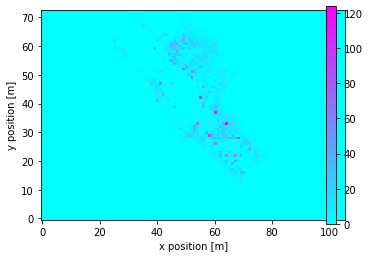

In [4]:

from helpers.waypoint_analyser import WaypointAnalyser
grid_res = 1
margin = 2
look_around_dist = 3

grid_x_min = 4
grid_x_max = 110
grid_y_min = -75
grid_y_max = -2

grid_limits = (grid_x_min, grid_x_max, grid_y_min, grid_y_max)


WPA = WaypointAnalyser(scene_data.traj_dataframe, grid_res, grid_limits, look_around_dist)
interest_areas = WPA.interest_area_searcher(savepath = 'data/images/WPA/areas.png')


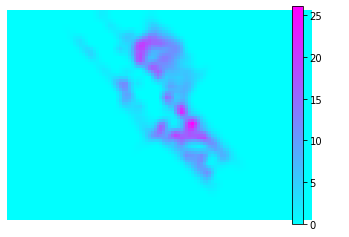

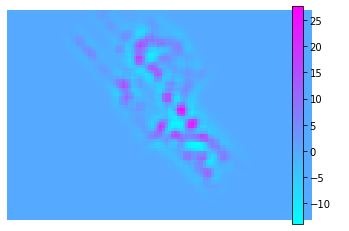

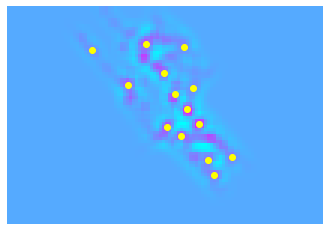

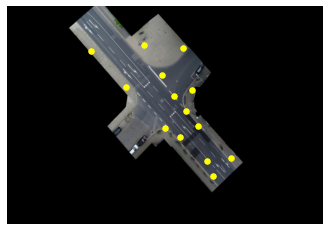

In [5]:
interest_points = WPA.interest_point_searcher(-interest_areas, savepath = 'data/images/WPA/points.png', 
min_dist = 4, thresh_rel=.2, kernel_size=3, hide_axes=True)

my_fig, my_ax = plt.subplots( nrows=1, ncols=1 )
scene_data.plot_on_image(interest_points, ax=my_ax, colors="yellow", ms=30, hide_axes=True, save_path='data/images/WPA/points_on_img.png')

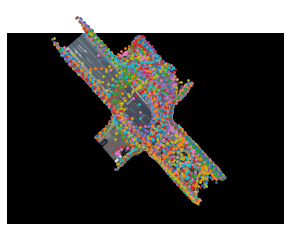

In [6]:
scene_data.plot_all_paths(save_path="data/images/WPA/all_paths.png", hide_axes=True)

## Make the graph

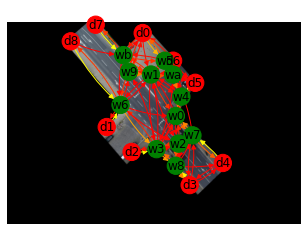

In [8]:
my_graph = g.create_graph(.05)
g.recalculate_trans_mat_dependencies()
g.visualize_graph(my_graph, 'data/images/graphs/graph_with_image.png', scene_loader = scene_data)

## Global Parameters

In [1]:
# Dataset parameters
#   PRE
DS_LOCATION = "data/pickle/ds_creation_d/all_f_fixed_length/ds_7to17_inputLabels.pickle"
SEQ_IN_LENGTH = 5
SEQ_OUT_LENGTH = 3
VARIABLE_INPUT_LENGTH = False
BATCH_SIZE=5
#   POST
NOISE_STD = .2
N_REPEATS = 1

# Model parameters
LSTM_LAYER_SIZE = 64
DENSE_LAYER_SIZE = 128
NUM_LSTM_LAYERS = 2
NUM_DENSE_LAYERS = 2

# Training parameters
MAX_EPOCHS = 100
PATIENCE = 10

## Training the models

#### Create Dataset 

In [33]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

extra_features_dict = {
        "all_points_after": None,
        "n_points_after": 6,
        "all_destinations": None,
    }

# Load data in order to not need to do calculations again
# with open(DS_LOCATION, 'rb') as handle:
#     my_ds_creation_dict = pickle.load(handle)

my_ds = TFDataSet.init_as_fixed_length(scene_data.traj_dataframe, graph=g, scale_list=["pos_x", "pos_y"], seq_in_length=SEQ_IN_LENGTH, label_length=SEQ_OUT_LENGTH, seq_stride=1,
extra_features_dict=extra_features_dict, noise_std=NOISE_STD, n_repeats = N_REPEATS, batch_size=BATCH_SIZE, save_folder=DS_LOCATION ) # ds_creation_dict=my_ds_creation_dict

100%|██████████| 76/76 [00:55<00:00,  1.36it/s]


#### Create Model

### Added Feature: All Destinations

In [28]:
my_trainer_all_dests = DLTrainer(max_epochs=MAX_EPOCHS, patience=PATIENCE)
my_trainer_all_dests.LSTM_one_shot_predictor_named_i(my_ds, LSTM_LAYER_SIZE, DENSE_LAYER_SIZE, 
NUM_LSTM_LAYERS, NUM_DENSE_LAYERS, extra_features=["all_destinations"], var_time_len=VARIABLE_INPUT_LENGTH)

print(my_trainer_all_dests.model.summary())

save_path = "data/model_weights/checkpoints/cp1.ckpt"

try:
    # first do one epoch of training in order to initialize weights
    my_trainer_all_dests.compile_and_fit(my_ds, 'data/model_weights/checkpoints/bin/cp1.ckpt', test_fit=True)
    my_trainer_all_dests.load_weights(save_path)
except:
    my_trainer_all_dests.compile_and_fit(my_ds, save_path)





5
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 2), dtype=tf.float32, name='in_xy'), name='in_xy', description="created by layer 'in_xy'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='flatten_28/Reshape:0', description="created by layer 'flatten_28'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 3), dtype=tf.float32, name='all_destinations'), name='all_destinations', description="created by layer 'all_destinations'")
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 62,726
Trainable params: 62,726
Non-trainable params: 0
__________________________________________________________________________________________________
None
1755/1755 [==============================] - 22s 10ms/step - loss: 0.0662 - mean_absolute_error: 0.1738 - val_loss: 0.0309 - val_mean_absolu

## Getting some accuracy stats

In [30]:
# Get an example path   
normed, denormed = my_ds.example_dict("train", "in_xy")
my_in_n, my_out_n = normed
my_in, my_out = denormed

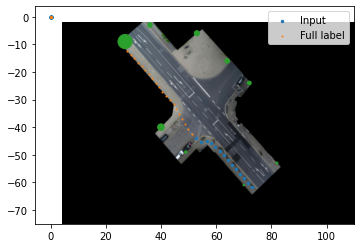

In [31]:
# Visualize an input path
fig_vis, ax_vis = plt.subplots()
id = 3
scene_data.plot_on_image([my_in["input_labels"][id], my_in["labels"][id]], 
save_path='data/images/extra_f/in_out.png', ms = [6, 1], ax=ax_vis,
col_num_dicts=[my_ds.generalised_in_dict, my_ds.generalised_out_dict],
labels=["Input", "Full label"])

dest_locs = my_in["all_destinations"][id][:, 0:2]
dest_probs = my_in["all_destinations"][id][:, 2:3]

scene_data.plot_dest_probs(dest_locs, dest_probs, 2, 200,
ax = ax_vis, save_path = None)

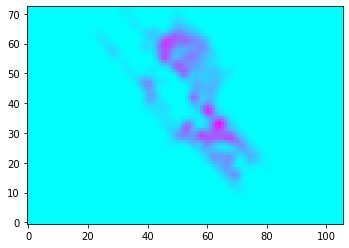

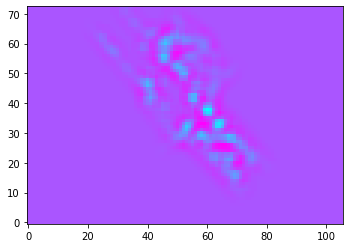

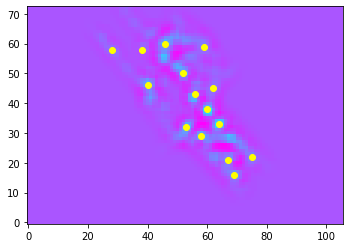

In [48]:
from helpers.waypoint_analyser import WaypointAnalyser
grid_limits = (4, 110, -75, -2)
grid_res = 1
margin = 2
look_around_dist = 3
WPA = WaypointAnalyser(scene_data.traj_dataframe, grid_res, grid_limits, look_around_dist)
# interest_areas = WPA.interest_area_searcher(savepath = 'data/images/WPA/areas.png')
interest_points = WPA.interest_point_searcher(interest_areas, savepath = 'data/images/WPA/points.png', min_dist = 4)


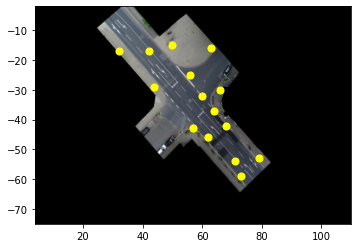

In [49]:
scene_data.plot_on_image([interest_points], colors = "yellow", ms=50)

In [50]:
# Do a prediction
predicted_out_n, predicted_out = my_trainer_all_dests.predict_dict(my_in_n, scale_input_tensor=False)
predicted_rep_out = my_trainer_all_dests.predict_repetitively_dict(my_in_n, scale_input_tensor=False,
num_repetitions=4,fixed_len_input=True)

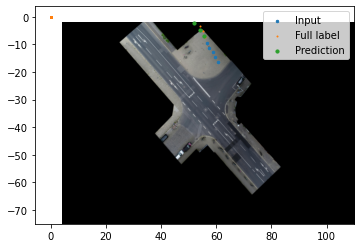

In [27]:
fig1, ax1 = plt.subplots()
id = 0
scene_data.plot_on_image([my_in["in_xy"][id], my_in["labels"][id], predicted_out[id]], 
save_path='data/images/extra_f/in_out.png', ms = [6, 1, 10], ax=ax1,
col_num_dicts=[my_ds.generalised_in_dict, my_ds.generalised_out_dict, my_ds.generalised_out_dict],
labels=["Input", "Full label", "Prediction"])

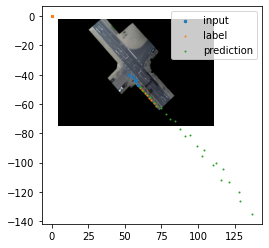

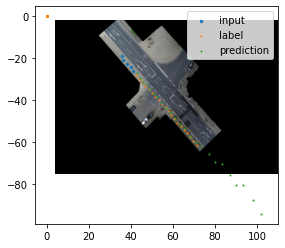

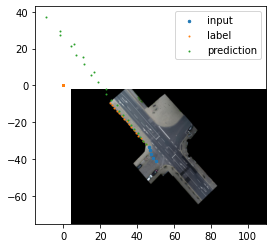

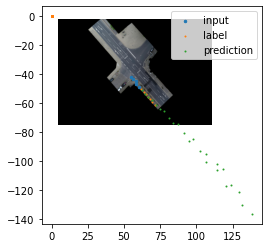

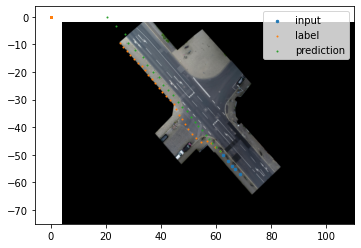

In [ ]:
figs=[]
axs=[]
for i in range(BATCH_SIZE): 
    id = i   
    fig, ax = plt.subplots()
    figs.append(fig)
    axs.append(ax)

    scene_data.plot_on_image([my_in["in_xy"][id], my_in["labels"][id], predicted_rep_out[id]], 
    save_path='data/images/extra_f/in_out.png', ms = [6, 1, 1], ax=axs[i],
    col_num_dicts=[my_ds.generalised_in_dict, my_ds.generalised_out_dict, my_ds.generalised_out_dict],
    labels=["input", "label", "prediction"])

### Get the statistics for this model

In [ ]:
# Getting an accuracy statistic

lst_accs = []
lst_accs_rep = []
for batch in iter(my_ds.tf_ds_dict["test"]):
    # Do a prediction
    predicted_out_n, predicted_out = my_trainer_all_dests.predict_dict(my_in_n, scale_input_tensor=False)
    predicted_rep_out = my_trainer_all_dests.predict_repetitively_dict(my_in_n, scale_input_tensor=False,
    num_repetitions=3,fixed_len_input=True)
    # Get the accuracies
    acc1 = return_batch_accuracy(predicted_out, my_in["labels"])
    acc2 = return_batch_accuracy(predicted_rep_out, my_in["labels"])
    # Get the 
    lst_accs = lst_accs + acc1[0]
    lst_accs_rep = lst_accs_rep + acc2[0]


np_accs = np.array(lst_accs)
np_accs_rep = np.array(lst_accs_rep)

tf.Tensor(
[[[-1.3185997  -0.90916955]
  [-1.1549456  -0.7939846 ]
  [-1.0455769  -0.71736926]
  [-0.9084162  -0.6298214 ]
  [-0.7749506  -0.537402  ]
  [-0.7044953  -0.5123866 ]
  [-0.63734436 -0.4748444 ]
  [-0.55566293 -0.5290704 ]]

 [[ 0.39344496 -0.21393725]
  [ 0.55109024 -0.29896373]
  [ 0.72438014 -0.4195083 ]
  [ 0.9016402  -0.5384133 ]
  [ 1.0735792  -0.6663796 ]
  [ 1.1076599  -0.78651565]
  [ 1.2506474  -0.9048212 ]
  [ 1.3178333  -1.0189772 ]]

 [[ 0.5623351  -0.30001006]
  [ 0.74117947 -0.40084302]
  [ 0.86777586 -0.55862695]
  [ 1.0505618  -0.6849732 ]
  [ 1.2286351  -0.7842107 ]
  [ 1.2332491  -0.9096768 ]
  [ 1.3737189  -1.0344604 ]
  [ 1.4281127  -1.1539705 ]]

 [[-0.42126974  1.6677616 ]
  [-0.36029828  1.5799865 ]
  [-0.31625676  1.474186  ]
  [-0.20869131  1.3671532 ]
  [-0.15267083  1.2441142 ]
  [-0.01226121  1.1718879 ]
  [ 0.00222966  1.0447494 ]
  [ 0.04423016  0.9027675 ]]

 [[-1.5826621   1.7012641 ]
  [-1.4399244   1.5583858 ]
  [-1.3294003   1.4350748 ]
 

In [ ]:
print(np.average(np_accs))
print(np.std(np_accs))
print(np.average(lst_accs_rep))
print(np.std(lst_accs_rep))

1.5022319718674377
0.5647728760606993
2.1711355212420185
1.234013181643873


### Influence of the destination

#### Let's edit the destination probability and see the consequence

In [ ]:
# Get an example path   
normed, denormed = my_ds.example_dict("train", "in_xy")
my_in_n, my_out_n = normed
my_in, my_out = denormed

In [ ]:
# Now adjust the deestination probs
# get one hot vector for 100% on one destination
dest_num = [3]
new_probs = tf.one_hot(
    [dest_num], 9, on_value=None, off_value=None, axis=None, dtype=tf.float32, name=None
)
new_probs = tf.reshape(new_probs, [-1, 1])
lst = [new_probs for i in range(BATCH_SIZE)]
print(new_probs)
new_probs=tf.stack(lst)

# implement the one hot vector
my_in_n_c = dict(my_in_n)
my_in_n_c["all_destinations"]=tf.concat([my_in_n["all_destinations"][:,:,0:2], new_probs], axis=-1)
my_in_c= dict(my_in)
my_in_c["all_destinations"]=tf.concat([my_in["all_destinations"][:,:,0:2], new_probs], axis=-1)

tf.Tensor(
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(9, 1), dtype=float32)


In [ ]:
# Do a prediction
predicted_out_n, predicted_out = my_trainer_all_dests.predict_dict(my_in_n_c, scale_input_tensor=False)
predicted_rep_out = my_trainer_all_dests.predict_repetitively_dict(my_in_n_c, scale_input_tensor=False,
num_repetitions=3,fixed_len_input=True)

(9, 1)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)


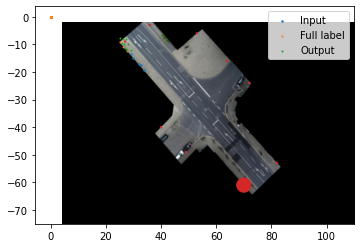

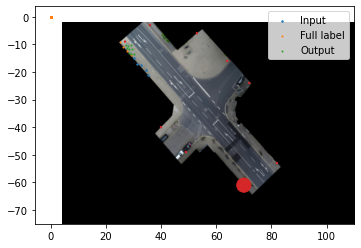

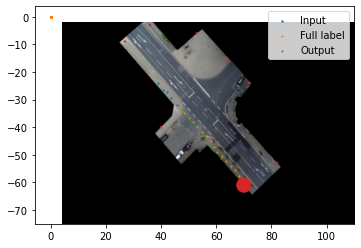

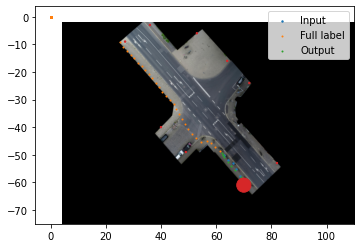

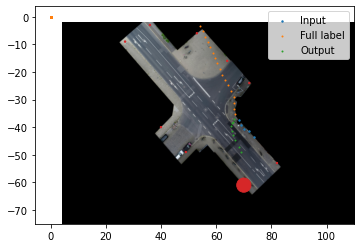

In [ ]:
# Visualize an input path

figs=[]
axs=[]
for i in range(BATCH_SIZE): 
    id = i   
    fig, ax = plt.subplots()
    figs.append(fig)
    axs.append(ax)
    scene_data.plot_on_image([my_in_c["in_xy"][id], my_in_c["labels"][id], predicted_rep_out[id]], 
    save_path=None, ms = [2, 1, 1], ax=axs[i],
    col_num_dicts=[my_ds.generalised_in_dict, my_ds.generalised_out_dict, my_ds.generalised_out_dict],
    labels=["Input", "Full label", "Output"])

    dest_locs = my_in_c["all_destinations"][id][:, 0:2]
    dest_probs = my_in_c["all_destinations"][id][:, 2:3]

    scene_data.plot_dest_probs(dest_locs, dest_probs, 2, 200,
    ax = axs[i], save_path = 'data/images/adjusted_dest/3/'+str(i)+'.png')

(9, 1)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)


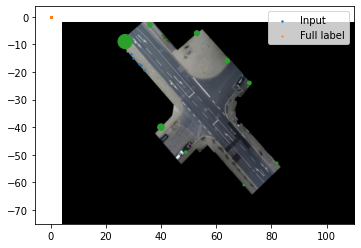

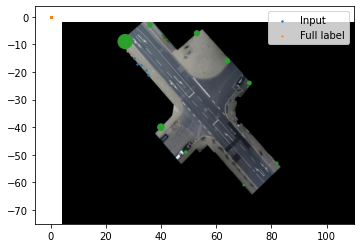

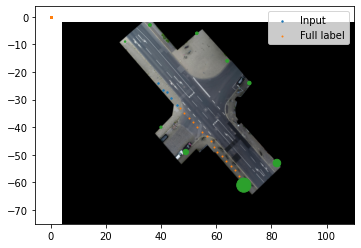

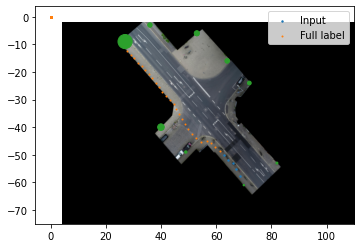

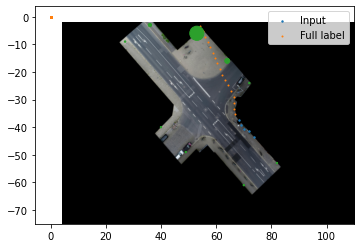

In [ ]:
# Visualize inputs and destination predictions without output predicrion

figs=[]
axs=[]
for i in range(BATCH_SIZE): 
    id = i   
    fig, ax = plt.subplots()
    figs.append(fig)
    axs.append(ax)
    scene_data.plot_on_image([my_in["in_xy"][id], my_in["labels"][id]], 
    save_path=None, ms = [2, 1, 1], ax=axs[i],
    col_num_dicts=[my_ds.generalised_in_dict,  my_ds.generalised_out_dict],
    labels=["Input", "Full label"])

    dest_locs = my_in["all_destinations"][id][:, 0:2]
    dest_probs = my_in["all_destinations"][id][:, 2:3]

    scene_data.plot_dest_probs(dest_locs, dest_probs, 2, 200,
    ax = axs[i], save_path = 'data/images/adjusted_dest/3/'+str(i)+'.png')

In [ ]:
path_df = scene_data.traj_dataframe.loc[scene_data.traj_dataframe["agent_id"] == 3]
path = path_df[["pos_x", "pos_y"]].to_numpy()
places,_ = g.analyse_full_signal(path, False)
print(places)
g.calculate_destination_probs(places,"destinations")

['wc' 'w4' 'w0' 'w7' 'w8' 'd3']


{'d0': 0.0012498809423475907,
 'd1': 0.046432574113721245,
 'd2': 0.23378745048445518,
 'd3': 0.850754408289402,
 'd4': 0.004125326474079936,
 'd5': 0.0012549599698038563,
 'd6': 0.0011884784679316804,
 'd7': 0.0}